In [181]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization , LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os
import PIL
import time
from IPython import display
import warnings 
warnings.filterwarnings("ignore")

In [182]:
import kagglehub
import time

# Download latest version
path = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)

Path to dataset files: /home/kifal/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3


In [183]:
path=pathlib.Path("/home/kifal/.cache/kagglehub/datasets/splcher/animefacedataset/versions/3")

In [184]:
batch_size = 32
data = keras.utils.image_dataset_from_directory(
    directory=path,
    label_mode=None,
    batch_size=batch_size,
    image_size=(64, 64),
)

Found 63565 files.


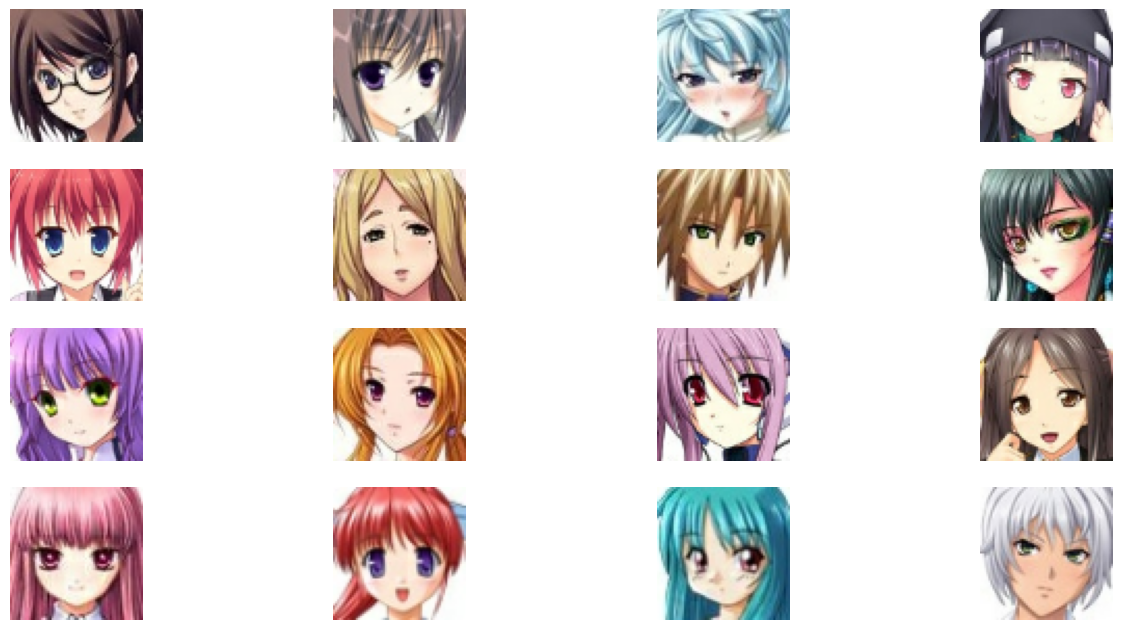

In [185]:
plt.figure(figsize=(16,10))
for images in data.take(12):
    for i in range(16):
        axis = plt.subplot(5, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")


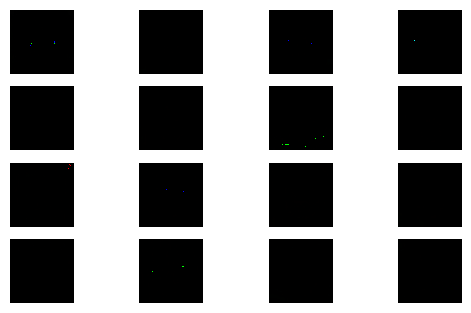

In [186]:
data = data.map(lambda x : (x-127.5)/127.5)
for images in data.take(1):
    for i in range(16):
        axis = plt.subplot(5,4,i+1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")



In [187]:
def build_discriminator():
  discriminator = Sequential()
  discriminator.add(Conv2D(filters=64, kernel_size=3, strides=(2,2), padding="same",  activation=keras.layers.LeakyReLU(alpha=0.01), input_shape=(64,64,3)))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters=128, kernel_size=3, strides=(2,2), padding="same",  activation=keras.layers.LeakyReLU(alpha=0.01)))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Conv2D(filters=256, kernel_size=3, strides=(2,2), padding="same", activation=keras.layers.LeakyReLU(alpha=0.01)))
  discriminator.add(BatchNormalization())
  discriminator.add(Dropout(0.2))

  discriminator.add(Flatten())
  discriminator.add(Dropout(0.2))
  discriminator.add(Dense(units=1, activation="sigmoid"))

  return discriminator


discriminator=build_discriminator()



In [188]:
latent_vector = 100

In [189]:
def build_generator():
  generator = Sequential()
  generator.add(Dense(units=4*4*256, input_shape =[latent_vector]))
  generator.add(Reshape((4,4,256)))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="relu"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="relu"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="relu"))
  generator.add(BatchNormalization())

  generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding ="same", activation ="tanh"))

  return generator




generator = build_generator()


In [190]:
optimizer = Adam(1e-4)

In [191]:
make_noise = tf.random.normal((1,latent_vector))
make_noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.94685143, -0.34686193, -0.1896571 , -0.37552044,  0.36888558,
        -0.33047786,  0.505188  ,  0.20230982, -0.58170843, -0.28107098,
         0.04576134,  0.7305785 , -0.11018124,  0.4236644 ,  0.35242617,
        -0.35070252, -1.0472319 , -0.6635934 , -0.9532984 , -0.262633  ,
         1.5206771 , -0.97961384, -0.9088474 , -0.3352119 ,  1.4890633 ,
        -0.5651123 , -1.7366953 ,  0.08581671, -1.6162635 , -0.96570325,
         0.71664596,  0.58993137, -0.48265427,  0.58446354,  0.2430016 ,
        -0.17593747, -0.6299772 ,  1.47517   ,  0.2907489 , -1.4216099 ,
        -1.2584678 , -0.48624316,  0.5628089 , -0.8628705 , -0.8212088 ,
         1.059695  , -0.62935126, -0.9792957 , -0.92855126, -0.73690784,
        -0.49176356, -0.6090589 , -1.2535349 ,  0.5041425 , -0.00763519,
         0.44689065, -0.03296662,  0.855765  ,  0.09400495,  2.1081426 ,
        -1.0399978 ,  0.59795666,  0.7430674 ,  0.75000554, -0.744468  ,
 

In [192]:
make_noises = generator(make_noise ,training=False)

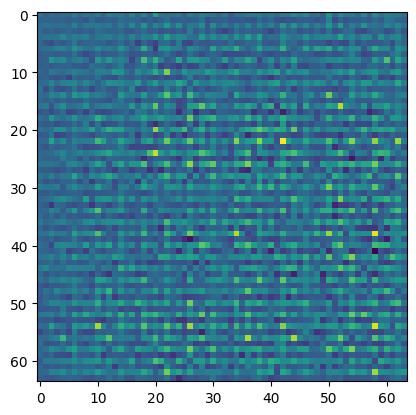

In [193]:
plt.imshow(make_noises[0 ,: ,: ,2])

In [194]:
d_optimizer = Adam(1e-4)
g_optimizer = Adam(1e-4)


In [195]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(seed)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [196]:
model = GAN(discriminator, generator, latent_vector)

In [197]:
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [198]:
model.compile(d_optimizer, g_optimizer, loss_fn=loss_fn)

In [199]:
print(model.summary())

Model: "gan_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_22 (Sequential)      │ (None, 1)              │       388,993 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_23 (Sequential)      │ (None, 64, 64, 3)      │     1,009,923 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,398,916 (5.34 MB)

 Trainable params: 1,396,740 (5.33 MB)

 Non-trainable params: 2,176 (8.50 KB)

None


In [201]:
epochs = 25
history = model.fit(data, epochs=epochs)

Epoch 1/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - d_loss: -0.6726 - g_loss: 706.5601
Epoch 2/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - d_loss: 0.5920 - g_loss: 4.7027
Epoch 3/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - d_loss: 0.3475 - g_loss: 3.2088
Epoch 4/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - d_loss: 0.3310 - g_loss: 2.3666
Epoch 5/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - d_loss: 0.3329 - g_loss: 2.5697
Epoch 6/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - d_loss: 0.3788 - g_loss: 2.4906
Epoch 7/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - d_loss: 0.3951 - g_loss: 2.2877
Epoch 8/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - d_loss: 0.4279 - g_loss: 1.9144
Epoch 9/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - d_loss: 0.4211 - g_loss: 1.9786
Epoch 10/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - d_loss: 0.3728 - g_loss: 2.1243
Epoch 11/25
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - d_loss: 0.3387 - g_loss: 2.3521
Epoch

KeyboardInterrupt: 

In [202]:
noise = tf.random.normal([32, 100])
generated_images = generator(noise, training=False)
generated_images

<tf.Tensor: shape=(32, 64, 64, 3), dtype=float32, numpy=
array([[[[ 0.96618795,  0.96014315,  0.9525749 ],
         [ 0.9841137 ,  0.98260397,  0.98042697],
         [ 0.9630753 ,  0.9626548 ,  0.9527308 ],
         ...,
         [ 0.9966957 ,  0.9942465 ,  0.9871686 ],
         [ 0.9799931 ,  0.9680044 ,  0.9451909 ],
         [ 0.93667436,  0.9065638 ,  0.89250726]],

        [[ 0.98527265,  0.97710735,  0.9772711 ],
         [ 0.97733027,  0.9784735 ,  0.980421  ],
         [ 0.9903054 ,  0.99043804,  0.9869786 ],
         ...,
         [ 0.99983567,  0.99947554,  0.99842834],
         [ 0.97355837,  0.973135  ,  0.9511277 ],
         [ 0.86769164,  0.82296187,  0.8146917 ]],

        [[ 0.99562407,  0.9910334 ,  0.9865827 ],
         [ 0.9899244 ,  0.9851641 ,  0.984552  ],
         [ 0.98616344,  0.97810453,  0.9767001 ],
         ...,
         [ 0.9998513 ,  0.9993922 ,  0.99877477],
         [ 0.9847996 ,  0.9646223 ,  0.94931227],
         [ 0.8639936 ,  0.8164588 ,  0.8021448 

In [203]:
generated_images1 = (generated_images+127.5)*127.5

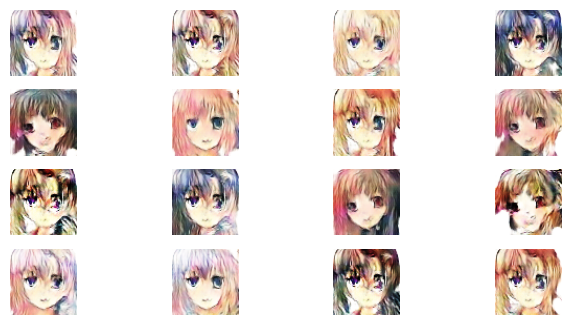

In [204]:
plt.figure(figsize=(8, 5))
for i in range(16):
    ax = plt.subplot(5, 4, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()

In [207]:
generator.save("generator.h5")